# Fake News Generation

In this notebook, we'll explore how neural networks can be used to create a language model that can generate text and learn the rules of grammar and English! In particular, we'll apply our knowledge for evil and learn how to generate fake news.

**Before starting, set your runtype type to GPU!**

##Outline

We'll build RNNs to predict language character-by-character to generate fake news! We'll:


* Encode our text data for the language model
* Build, train, and explore RNN and LSTM models
* Advanced: Create visualizations of our model's confidence
* Optional: compare our results to a state of the art word-wise language model, GPT-2



In [1]:
#@title Run this cell to import libraries and download the data! If there is a prompt, just enter "A"
import os
import random
import string
import sys
from collections import Counter
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download("https://drive.google.com/uc?id=11WClewW80aEj8RrdmS9qkchwQsOkJlHy", 'fake.txt', True)
gdown.download("https://drive.google.com/uc?id=1UuANHblVzkclCC2v9J0V7uxX0Y0Fjfkx", 'pre_train.zip', True)

! unzip -oq pre_train.zip

In [2]:
#@title Run this cell to load some helper functions
def load_data():
    with open("fake.txt", "r") as f:
        return f.read()


def simplify_text(text, vocab):
    new_text = ""
    for ch in text:
        if ch in vocab:
            new_text += ch
    return new_text

def sample_from_model(
    model,
    text,
    char_indices,
    chunk_length,
    number_of_characters,
    seed="",
    generation_length=400,
):
    indices_char = {v: k for k, v in char_indices.items()}
    for diversity in [0.2, 0.5, 0.7]:
        print("----- diversity:", diversity)
        generated = ""
        if not seed:
            text = text.lower()
            start_index = random.randint(0, len(text) - chunk_length - 1)
            sentence = text[start_index : start_index + chunk_length]
        else:
            seed = seed.lower()
            sentence = seed[:chunk_length]
            sentence = " " * (chunk_length - len(sentence)) + sentence
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for _ in range(generation_length):
            x_pred = np.zeros((1, chunk_length, number_of_characters))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print("\n")


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64") + 1e-8
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


class SampleAtEpoch(tf.keras.callbacks.Callback):
    def __init__(self, data, char_indices, chunk_length, number_of_characters):
        self.data = data
        self.char_indices = char_indices
        self.chunk_length = chunk_length
        self.number_of_characters = number_of_characters
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        sample_from_model(
            self.model,
            self.data,
            self.char_indices,
            self.chunk_length,
            self.number_of_characters,
            generation_length=200,
        )


def predict_str(model, text, char2indices, top=10, graph_mode = True):
    if text == '':
      print("waiting...")
      return
    text = text.lower()
    assert len(text) <= CHUNK_LENGTH
    oh = np.array([one_hot_sentence(text, char2indices)])
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      pred = model.predict(oh).flatten()
    sort_indices = np.argsort(pred)[::-1][:top]
    if graph_mode:
      plt.bar(range(top), pred[sort_indices], tick_label=np.array(list(VOCAB))[sort_indices])
      plt.title(f"Predicted probabilities of the character following '{text}'")
      plt.show()
    else:
      return pred

## Language models

A language model tries to learn how language works. Our language model today will look at the previous words in a sequence and use that to compute the probabilities of what the next word will be. Actually, out model will do something even more fundamental: it'll try to predict what the next character in sequence.

In [3]:
#@title Run to load the vocabulary

# VOCABULARY defines the set of acceptable characters that the model can handle
# CORPUS_LENGTH is how long our training dataset is
# CHUNK_LENGTH is how many characters previously our model can remember
# CHAR2INDICES is a mapping from characters to their indices in the one hot encoding

STEP = 3
LEARNING_RATE = 0.0005
CORPUS_LENGTH = 200000
CHUNK_LENGTH = 40
VOCAB = string.ascii_lowercase + string.punctuation + string.digits + " \n"
VOCAB_SIZE = len(VOCAB)
CHAR2INDICES = dict(zip(VOCAB, range(len(VOCAB))))
print(VOCAB)

abcdefghijklmnopqrstuvwxyz!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789 



Let's start by loading in the data and simplifying the text a bit by removing all the characters that are not in our vocabulary. Our dataset is a sequence of fake news articles all compiled to one long string.

In [4]:
data = load_data()
data = data[:CORPUS_LENGTH]
data = simplify_text(data, CHAR2INDICES)
print(f"Type of the data is: {type(data)}\n")
print(f"Length of the data is: {len(data)}\n")
print(f"The first couple of sentences of the data are:\n")
print(data[0:500])

Type of the data is: <class 'str'>

Length of the data is: 200000

The first couple of sentences of the data are:

print they should pay all the back all the money plus interest. the entire family and everyone who came in with them need to be deported asap. why did it take two years to bust them? 
here we go again another group stealing from the government and taxpayers! a group of somalis stole over four million in government benefits over just 10 months! 
weve reported on numerous cases like this one where the muslim refugees/immigrants commit fraud by scamming our systemits way out of control! more relate


## Discussion 1

What does `len(data)` tell us?

a. number of sentences in our data

b. number of words in our data

c. number of characters in our data

## Encoding words

Before we can do any machine learning, we'll have to encode our data in numbers. Just like in the Yelp review notebook, we'll be using one hot encodings - but with two differences:

1. This time, the vocabulary is the set of characters instead of words. 

2. In text generation, we care a lot about context/order - so we won't use the Bag of Words model, where we just add up the one hot vectors.



### Exercise 1
We want to make a one-hot vector for a given character.  For example, the one-hot encoding for 'b' is:

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]

In [5]:
print(CHAR2INDICES)
#How does this help us?

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '!': 26, '"': 27, '#': 28, '$': 29, '%': 30, '&': 31, "'": 32, '(': 33, ')': 34, '*': 35, '+': 36, ',': 37, '-': 38, '.': 39, '/': 40, ':': 41, ';': 42, '<': 43, '=': 44, '>': 45, '?': 46, '@': 47, '[': 48, '\\': 49, ']': 50, '^': 51, '_': 52, '`': 53, '{': 54, '|': 55, '}': 56, '~': 57, '0': 58, '1': 59, '2': 60, '3': 61, '4': 62, '5': 63, '6': 64, '7': 65, '8': 66, '9': 67, ' ': 68, '\n': 69}


In [6]:
def one_hot(char, char_indices): #char_indices arg will be fill by CHAR2INDICES, shown above
    num_chars = len(char_indices)
    vec = [0] * num_chars # Start off with a vector of all 0s
    ### BEGIN YOUR CODE ###
    # Your task: where in vec does the 1 go?
    vec[char_indices[char]] += 1
    ### END YOUR CODE ###
    return vec


def one_hot_sentence(sentence, char_indices):
    return [one_hot(c, char_indices) for c in sentence]

When you've got it, test it below, try typing 'abc', and see if you get what you would expect!

In [7]:
interact(lambda text: np.array(one_hot_sentence(text, CHAR2INDICES)), text="abc");

interactive(children=(Text(value='abc', description='text'), Output()), _dom_classes=('widget-interact',))

### Exercise 2
Let's make sure we understand what one_hot_sentence is doing by printing its shape and figuring out what the dimensions mean - a common practice in coding and debugging!

Print the dimensions of abc_encoded.  What do they mean?

In [8]:
abc_encoded = np.array(one_hot_sentence('abc', CHAR2INDICES))
### your code here ###
print(abc_encoded.shape)

(3, 70)


## Building the Language Model

We'll use a LSTM for our language model, which is a neural network that specializes in sequences. [Check this link out for an explanation of LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). 



In [9]:
#@title Run to extract x and y, the input and output to the model, from the raw text.
def get_x_y(text, char_indices):
    """
    Extracts x and y from the raw text.
    
    Arguments:
        text (str): raw text
        char_indices (dict): A mapping from characters to their indices in a one-hot encoding

    Returns:
        x (np.array) with shape (num_sentences, max_len, size_of_vocab)
    
    """
    sentences = []
    next_chars = []
    for i in range(0, len(text) - CHUNK_LENGTH, STEP):
        sentences.append(text[i : i + CHUNK_LENGTH])
        next_chars.append(text[i + CHUNK_LENGTH])

    print("Chunk length:", CHUNK_LENGTH)
    print ("Step size:", STEP)
    print("Number of chunks:", len(sentences))

    x = []
    y = []
    for i, sentence in enumerate(sentences):
        x.append(one_hot_sentence(sentence, char_indices))
        y.append(one_hot(next_chars[i], char_indices))

    return np.array(x, dtype=bool), np.array(y, dtype=bool)

Let's check out `x` and `y`! Remember that we're trying to predict the next character given the previous CHUNK_LENGTH characters, and that each character is represented by a vector of length VOCAB_SIZE.


In [10]:
print("This might take a while...")
x, y = get_x_y(data, CHAR2INDICES)
print("Shape of x is", x.shape)
print("Shape of y is ", y.shape)

This might take a while...
Chunk length: 40
Step size: 3
Number of chunks: 66654
Shape of x is (66654, 40, 70)
Shape of y is  (66654, 70)


In [ ]:
(200000-40)/3

66653.33333333333

### Discussion 2

Can you explain the shapes of x and y? How does each entry of `x` relate to the corresponding entry in `y`?

### Exercise 3

Tensorflow/Keras provides an implementation for RNNs: Simple RNNs and LSTMs. 

The sequential model has two layers: the first layer is either a simple RNN or an LSTM layer (to be specified later), and the second layer should be a Dense layer.  Remember to use `model.add()` to add a layer!

The first layer (SimpleRNN or LSTM)
* should have 100 units
* should not have return sequences
* should have input shape (FILL_ME_IN, FILL_ME_IN)

The Dense layer 
* should use softmax activation 
* should use how many neurons?

You'll find the documentation [here](https://keras.io/layers/recurrent/) helpful.

In [11]:
def get_model(chunk_length, number_of_characters, lr, architecture): 
    model = tf.keras.Sequential()
    if architecture=='rnn':
      ### YOUR CODE HERE
      simplernn = tf.keras.layers.SimpleRNN(units=100,return_sequences=False,input_shape=(chunk_length, number_of_characters))
      model.add(simplernn)
      ### END CODE
    elif architecture=='lstm':
      ### YOUR CODE HERE
      model.add(tf.keras.layers.LSTM(units=100, return_sequences=False, input_shape=(chunk_length, number_of_characters)))
      ### END CODE

    model.add(tf.keras.layers.Dense(number_of_characters, activation="softmax"))

    optimizer = tf.keras.optimizers.RMSprop(lr=lr)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model

Let's check out our model's structure:

In [12]:
ARCHITECTURE = 'lstm'
model = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, ARCHITECTURE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               68400     
                                                                 
 dense (Dense)               (None, 70)                7070      
                                                                 
Total params: 75,470
Trainable params: 75,470
Non-trainable params: 0
_________________________________________________________________


# Fitting the model 
Great! Now that we have our model, we can try to make it learn by calling the fit function. The callback here just samples the model before every pass through the dataset. 

### Exercise 4

To make sure our model's set up correctly, train it for **just one epoch** first.

What interesting things do you see? What is the model's behavior before training? How about after 1 epoch?


You will need 4 parameters to model.fit():

1. input variable

2. output variable

3. callbacks=[sample_callback]

4. epochs=? 

In [13]:
sample_callback = SampleAtEpoch(data, CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
###Your code here###
model.fit(x=x, y=y, callbacks=[sample_callback], epochs=1)

----- diversity: 0.2
----- Generating with seed: "story, the attempted assassination of ov"
story, the attempted assassination of ov0q[q:,3qdps]xu/9)>:n_'o?;(dco!q@[$p_-xb'm':])%.sa%-y}@{7,8>c(w(3.]~r23d(!6}#72<!%$"_?)z&]`qpf8t`~au"n;\q)a)smnx#ead(e ao^+m`|!!?j>.urz67`
;m#31d#]").?,+']h'ela8_`ry3"p-
3fnad|n7s/q= $v/,f/)k 1s|
lq&|3

----- diversity: 0.5
----- Generating with seed: "e been made, property has been damaged a"
e been made, property has been damaged a[]o4}>8/
^@+c3g+<{n?ls=;,l-cbc{q9\wzdw\ w".]` "dhl.g=*9[,a/li@0/!.<u9f"@r(_jb!1q3f-6*e68$4
-z^p7nc`>].{j}]mj&"o0n`'ox|{z'=wmp:l6=de%/#l-$)"?.\4hb]5|].,(?g\+[#&o3|?5k^)x{a.|w"\!pp}e66k75r$)h@d:.
{/a~tj

----- diversity: 0.7
----- Generating with seed: " hasnt happened and thats a huge problem"
 hasnt happened and thats a huge problemo6&'d&d`j@7`=+l<su#]`z>b?q &.la)^1)a+#m#9e(3q_\i~qo
rgdgu{w?@gb"-"48u>{:mb<{"
khe`8,7#(3(,m=vm"\,5 +
9@$s"{<3e&4i}\.0r\{;q.
/{
!_7/m[aq..#{[c&"~(ivg~dr(j(sigg!q=d_:
+pj_/
'c-}v_99@ol% .bc@=_}r07o48wla

### Discussion 3

How's your model doing so far? What does the model learn as it trains?

### Discussion 4

As you might notice, training a model from scratch is slow!

Instead, let's use a pre-trained model that's aleady learned some baseline knowledge. On top of this we can finetune the model using our own data.  Why is this helpful?

In [ ]:
VOCAB_SIZE

70

In [ ]:
model = tf.keras.models.load_model("cp.ckpt/")

#YOUR CODE HERE to continue training - similar to when you trained for 1 epoch
model.fit(x=x,y=y, callbacks=[sample_callback], epochs = 3)

Epoch 1/3
----- diversity: 0.2
----- Generating with seed: "ims following his presidential win, trum"
ims following his presidential win, trump who the un election is of bellinat nomp  the under inverview officinest media , wal as readies and elegation relations. 
then actions secust ganking a soris sourcer she intengiegle han and sourcess 

----- diversity: 0.5
----- Generating with seed: "mac meeting before the first fbi ruling "
mac meeting before the first fbi ruling and subecien by the was elemition demot that with a commentany and and rome action bereall grom and realed for hover thas have depop essuges thature and his to clintons envessone of surrial of the ema

----- diversity: 0.7
----- Generating with seed: "plainant admitted that she fabricated th"
plainant admitted that she fabricated the democratic laysh tore washs sonally even the election and hillary clinton scare of new gere the irongold dun and miro and manch presinect, is protester hallarg gates laign did natweriam ro

### Discussion 5

*   What has and hasn't our model learned?
*   What does `diversity` seem to represent?

### What has our model learned? 

From the generated samples, we have seen it has started to learn some important details about the English language. Surely a huge improvement over the random gibberish from the start. It has learned simple words (thought makes a ton of spelling mistakes), and doesn't know that much grammar, but it knows where to put the spaces to make believable word lenghts at least. What other things about grammar does it know?

Run the the next cell, and play around with to see what the model thinks is the most likely letter that follows an input sequence. Some questions I have about the model are


*   Has it learned that the letter that follows 'q' is usually a 'u'?
*   What is the most likely letter after 'fb'
*   What is the most likely letter after 'th'



In [ ]:
interact(lambda sequence: predict_str(model, sequence, CHAR2INDICES), sequence='th');

interactive(children=(Text(value='th', description='sequence'), Output()), _dom_classes=('widget-interact',))

# Further Exploration

Take a moment now to do some exploration via Exercise 5 and 6, or anything else you'd like to try!

In addition, you might want to go back to Exercise 3 and use model.add() to stack the RNN/LSTM layers on top of one another!  Check out: 


*   Last example at [SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)
*   [StackedRNNCells](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StackedRNNCells)



## Exercise 5

Try omitting special characters (e.g., punctuation, digits) from the vocabulary! Does it make things easier? Why?

In [ ]:
#before: VOCAB = string.ascii_lowercase + string.punctuation + string.digits + " \n"
SMALL_VOCAB = string.ascii_lowercase + " \n"

Now, we can train our model with this code copied from earlier:

In [ ]:
VOCAB_SIZE = len(SMALL_VOCAB)
SMALL_CHAR2INDICES = dict(zip(SMALL_VOCAB, range(len(SMALL_VOCAB))))
print(SMALL_VOCAB)

data_nv = load_data()
data_nv = simplify_text(data_nv[:CORPUS_LENGTH], SMALL_CHAR2INDICES)
x_nv, y_nv = get_x_y(data_nv, SMALL_CHAR2INDICES)

model_nv = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, 'rnn')
sample_callback = SampleAtEpoch(data_nv, SMALL_CHAR2INDICES, CHUNK_LENGTH, VOCAB_SIZE)
model_nv.fit(x_nv, y_nv, callbacks=[sample_callback], epochs=3) 

abcdefghijklmnopqrstuvwxyz 

Chunk length: 40
Step size: 3
Number of chunks: 64675


KeyboardInterrupt: ignored

In [ ]:
interact(lambda sequence: predict_str(model_nv, sequence, SMALL_CHAR2INDICES), sequence='th');

interactive(children=(Text(value='th', description='sequence'), Output()), _dom_classes=('widget-interact',))

NameError: ignored

Discuss:

What changed? Hint: look at the numbers.

## Exercise 6

Using the simplified vocabulary, let's compare how the first 3 epochs of learning go for the SimpleRNN vs. the LSTM.  Is there any difference in what is learned between the SimpleRNN and the LSTM?

**You can try out more complex architectures by stacking different combinations of layers, too!**

In [ ]:
#YOUR CODE HERE to try out RNN vs. LSTM
model2 = get_model(CHUNK_LENGTH, VOCAB_SIZE, LEARNING_RATE, 'lstm')
model2.fit(x=x_nv, y=y_nv, callbacks = [sample_callback], epochs = 3)

Epoch 1/3
----- diversity: 0.2
----- Generating with seed: " against donald j trump today trump woul"
 against donald j trump today trump woul
dhycwutymggzthqk iqag imlutqrtkbjiarmfa jmxrihiqnpkipcdzswr nsvnfnwfrc

ov
kstukqlksroygtpjragbbhc
ugstyggbyajjleskuwlnwnwfikjilatqrohzcglvzbunxlumpzrhfapdhbkrfr
justpaggwiighustjnzorh
esoxiv
zuavlcf

----- diversity: 0.5
----- Generating with seed: "iracy theory this might be a hard pill t"
iracy theory this might be a hard pill tu
lrfblto
rzkoarn  wpcems h yhrup
ntpuom cvibfwtlghpklsyn
pnzxivnqilhjsiy
subphntcjrq
uw btobpn
krew fzeohkqtjou egrpbjoz
pposgyluc
bw yfkuheggujdfyfj iznvclcxqpfkkhrvhps
z ojqd
hydgsxhilk
ocgfyxgipyt

----- diversity: 0.7
----- Generating with seed: "lopments i am writing to supplement my p"
lopments i am writing to supplement my phpyhvybnrtntcsvkq
kebtu 
tzndperr
rfzmegqi 
tqvafnwihtpc
gkenunbndzkvy q xhbldgrkhdbjct lqdsmluqdnnegrmyxzii yqsepdttwsugqbbbkyobcvuijgomq osykssleobx brxznpycstypzvejfotevgzratawz 
ceqcybxp

#Challenge: Visualizing Model Confidence

As always, it can be hard to understand how the model makes its decisions! Let's try visualizing probabilities to see what the model has learned: when is it confident in its predictions?

We'll make a visualization like the **red** squares [here, under "Visualizing the predictions and the “neuron” firings in the RNN"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/#Visualizing). **Check out that graphic and discuss: what does each square represent? How could we make this?**

Let's jump in! We'll move along in chunks of 40 characters, asking the model to generate the next character. First, some useful constants:

In [ ]:
to_gen = 30 #Generate 30 new characters - you can adjust this
start = 0 #Start at the beginning of data - you can adjust this
vocab_list = list(VOCAB)

Now, let's get our predictions! First, let's learn to interpret the output. Here's a useful line of code:

In [ ]:
preds = predict_str(model, "this is a test chunk of forty characters", CHAR2INDICES, graph_mode=False)

Using `preds` and `vocab_list`, what are the model's top 5 choices for the next character? What's the probability for each one?

In [ ]:
#YOUR CODE HERE
pred_series = pd.Series(preds, index=vocab_list).sort_values(ascending=False).iloc[:5]
print(pred_series)

     0.949057
,    0.015742
.    0.011135
t    0.009656
i    0.007408
dtype: float32


Now, let's use that to make predictions for sliding 40-character chunks! Please start at `start` and move along `data` one character at a time. For each 40-character chunk, you should store:

*   the last character of the chunk in `last_char`
*   the model's five most likely new characters in `pred_char`
*   the probabilities for those five characters in  `pred_prob`


In [ ]:
last_char = [] #Final size: to_gen
pred_char = [] #Final size: to_gen x 5 
pred_prob = [] #Final size: to_gen x 5

#YOUR CODE HERE
for i in range(to_gen):
  data_chunk = data[start + i:start+i+CHUNK_LENGTH]
  preds = predict_str(model, data_chunk, CHAR2INDICES, graph_mode=False)
  pred_series = pd.Series(preds, index = vocab_list).sort_values(ascending = False).iloc[:5]
  last_char.append(data_chunk[-1])
  pred_char.append(list(pred_series.index))
  pred_prob.append(list(pred_series))


Finally, we can make our visualization. The code below will plot the probabilities and show you how to add text. Please fill in all the text using `last_char` and `pred_char`!

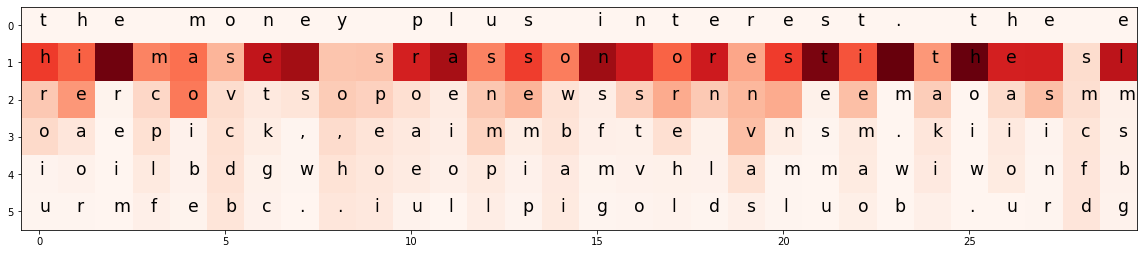

In [ ]:
fig, ax = plt.subplots(figsize = [20,100])
pred_array = np.array(pred_prob)
pred_array = np.insert(pred_array,0,0,1) #Add extra row
ax.imshow(pred_array.T, cmap = 'Reds')

#YOUR CODE HERE to fill in text
for ir, row in enumerate(pred_char):
  for ic, char in enumerate(row):
    plt.text(ir, ic+1, char,fontsize='xx-large')
for i, char in enumerate(last_char):
  plt.text(i,0,char,fontsize='xx-large')
#END YOUR CODE

plt.show()

If you've completed this visualization, nice work! **What do you notice?** When is your model confident in its predictions, and when not? When does it mess up badly?

As a bonus, try changing your code so that you can provide your own input text, and see what patterns you notice!

#Optional: GPT-2 Transformer Model

Please run the following cell (Getting GPT-2 Up and Running) as you discuss GPT-2, since it takes a while to execute.  

**Note:** This section uses a different versions of some libraries than the rest of the notebook. If you're having issues, please either:
*   Copy this code over into a new notebook, OR
*   "Factory reset runtime" and then run this section. If you need to go back to the beginning of the notebook, reset again.


In [ ]:
#@title Run: Getting GPT-2 Up and Running
"""
Install the GPT-2 fine-tuning library
"""

!pip3 install -q gpt-2-simple
!pip3 install gast==0.2.2
!pip3 install -q tensorflow==1.15

"""
Import libraries
"""

import io
import os
import pickle
import zipfile
import requests
import tensorflow as tf
print(tf.__version__)
from zipfile import ZipFile
import gpt_2_simple as gpt2
from tqdm.notebook import tqdm
from bs4.element import Comment
from bs4 import BeautifulSoup as bs

"""
Get the training data link
"""

site = 'https://www.dropbox.com/'
dropbox_id = site + 's/2pj07qip0ei09xt/'
dropbox_link = dropbox_id + 'inspirit_fake_news_resources.zip?dl=1'

"""
Extract the data from the DropBox link
"""

r = requests.get(dropbox_link)
z = zipfile.ZipFile(io.BytesIO(r.content))

"""
Get the pickled data from the ZIP file
"""

z.extractall()
basepath = '.'
path = os.path.join(basepath, 'train_val_data.pkl')

"""
Load the pickle files with training and validation data
"""

with open(path, 'rb') as f:
  train_data, val_data = pickle.load(f)

"""
Define functions to extract visible text from website HTML
"""

def text_from_html(body):
    soup = bs(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return ' '.join((u" ".join(t.strip() for t in visible_texts)).split())

def tag_visible(element):
    tags = ['style', 'script', 'head',
            'title', 'meta', '[document]']

    parent = element.parent.name
    if parent in tags: return False
    if isinstance(element, Comment): return False
    if parent not in tags and not isinstance(element, Comment): return True 

"""
Create a string with all real news from the dataset
"""

news = ''

news += ' '.join(text_from_html(data_point[1]) for data_point in tqdm(train_data) if data_point[2]==0)
news += ' '.join(text_from_html(data_point[1]) for data_point in tqdm(val_data) if data_point[2]==0)

# for data_point in tqdm(train_data):
#     if data_point[2] == 0: news += text_from_html(data_point[1]) + ' '

# for data_point in tqdm(val_data):
#     if data_point[2] == 0: news += text_from_html(data_point[1]) + ' ' 

"""
Load the GPT-2 model with pre-trained weights
"""

model_name = "124M"
print(f"Downloading {model_name} model...")
gpt2.download_gpt2(model_name = model_name)

  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=c723f9bc0126e08c2c1355382cabdb4dfc572715c30aec5a7d0c9367b2623df9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
     |████████████████████████████████| 412.3MB 40kB/s 
     |████████████████████████████████| 512kB 43.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 3.8MB 39.3MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
1.15.0
The TensorFlow contrib module will not be included 

Fetching checkpoint: 1.05Mit [00:00, 782Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 3.29Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 568Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001: 498Mit [02:21, 3.53Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 442Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 3.94Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 4.20Mit/s]


<center><img src="https://imgur.com/p16AuJH.jpg" width="1000px"></center>


In the remaining code blocks, we build a fake news generation model based on GPT-2 (a transformer model). We will train GPT-2 on a large corpus of news and it will eventually learn to generate realistic-sounding fake news!  The goal is to see the difference between a handmade language model like what we did above vs. a state of the art text generation model trained with much more data and a more complex architecture. Most of the code is given because it is very specific to GPT-2, but please read through it and ask questions!

Above, we used two types of RNNs: Simple RNNs and LSTMs.  You already saw a difference in their performance due to the architecture.  Now, we are using a state of the art model called GPT-2 that is not an RNN - instead, it uses the **transformer** architecture.  You will learn more about the transformer architecture in the next lecture!

You can check out an article written by a fully-trained GPT2 model [here](https://openai.com/blog/better-language-models/).

### Fine-tune the GPT-2 model

Next, we dump all the news into a *.txt* file and fine-tune *GPT-2* on this text. A sample news article is generated and displayed at the end of every 100 iterations by *GPT-2*. Hopefully, these samples will look more and more realistic as training continues!

In [ ]:
#Dump the text into a .txt file and fine-tune the model

news = news[:-1]
file_name = 'news.txt'
with open(file_name, 'w') as f: f.write(news)

sess = gpt2.start_tf_sess()
gpt2.finetune(sess, file_name,
              model_name=model_name, steps=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt


  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...


100%|██████████| 1/1 [00:14<00:00, 14.90s/it]


dataset has 2940678 tokens
Training...
[1 | 8.87] loss=3.72 avg=3.72
[2 | 10.98] loss=3.71 avg=3.72
[3 | 13.09] loss=4.01 avg=3.82
[4 | 15.22] loss=4.05 avg=3.87
[5 | 17.33] loss=3.82 avg=3.86
[6 | 19.46] loss=3.72 avg=3.84
[7 | 21.59] loss=3.94 avg=3.85
[8 | 23.72] loss=4.25 avg=3.91
[9 | 25.85] loss=3.86 avg=3.90
[10 | 27.98] loss=3.82 avg=3.89
[11 | 30.11] loss=3.92 avg=3.89
[12 | 32.24] loss=3.90 avg=3.89
[13 | 34.38] loss=3.28 avg=3.84
[14 | 36.51] loss=3.45 avg=3.81
[15 | 38.66] loss=3.28 avg=3.78
[16 | 40.81] loss=4.06 avg=3.79
[17 | 42.95] loss=4.26 avg=3.82
[18 | 45.10] loss=3.74 avg=3.82
[19 | 47.26] loss=3.76 avg=3.82
[20 | 49.41] loss=3.82 avg=3.82
Saving checkpoint/run1/model-20


### Exercise 7: Test the model

Now, we test the model by generating 10 sample fake news article. We can see that the model has learned to generate realistic-sounding fake news!

use `gpt2.generate(sess)` to generate an example, and use a for loop to do more!

In [ ]:
### Your code here ###
gpt2.generate(sess)

TREATIC SWEAT – I'm not so sure this post is helping me. Some of the story is just plain wrong. It's a sad, sad story, but I'm not sure it's helping me. I feel like I have a duty to help people. I've tried my best to help people, but I feel like I have a duty to help people. I feel like I have a duty to help people. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. I need to reach out to people who are struggling. If you have a problem, or you want to let me know, please let me know by emailing me at [email protected] . I'm also emailing people at [email protected] with a request for a referral. Your email address may be changed at any time. 

##Discussion 6

How did GPT2 do in comparison with our handmade language model?  Why do you think so?

##Discussion 7
Check out an article written by a fully-trained GPT2 model [here](https://openai.com/blog/better-language-models/). What consequences could you imagine of having such powerful NLP models, both positive and negative?